In [1]:
from collections import defaultdict
import numpy as np
import random
from sklearn import linear_model
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def readCSV(path):
    f = open(path)
    f.readline()
    for l in f:
        ui,si,su,ts,te = l.strip().split(',')
        yield ui,si,su,int(ts), int(te)

In [3]:
def Jaccard(s1, s2):
    numer = len(s1.intersection(s2))
    denom = len(s1.union(s2))
    if denom > 0:
        return numer/denom
    return 0

In [4]:
data = []
for l in readCSV('100k_a.csv'):
    data.append(l)

In [5]:
len(data)

3051732

In [6]:
data[0]

('1', '33846768288', 'alptv', 166, 169)

In [7]:
freq = pd.Series([d[2] for d in data]).value_counts()
freq=freq[freq>=1000]
len(freq)

429

In [8]:
#plt.hist(freq.values,bins=np.histogram_bin_edges(freq.values, bins=30)) 
#plt.title("Distribution of streamers with watch frequencies over 1000") 
#plt.show()

<AxesSubplot:title={'center':'Density distribution of streamers with watch frequency over 1000'}, ylabel='Density'>

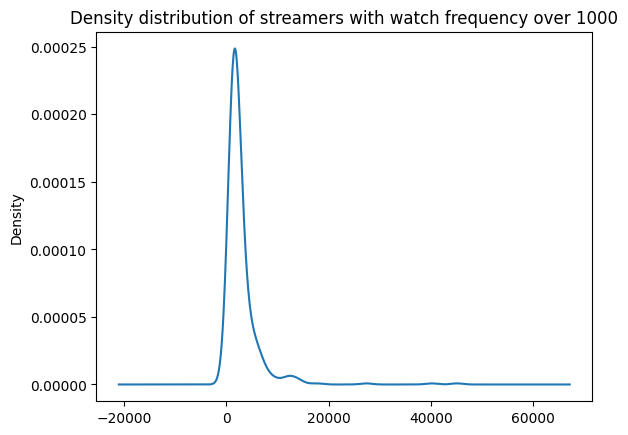

In [9]:
freq.plot(kind = 'kde', title="Density distribution of streamers with watch frequency over 1000")

# Watch predict

In [36]:
# shuffle and split data
from sklearn.model_selection import train_test_split
datasmaller,other = train_test_split(data,test_size=0.67)
dataTrain,dataValidTest = train_test_split(datasmaller,test_size = 0.5)
dataValid,dataTest = train_test_split(dataValidTest,test_size = 0.5)
othervalid,_ = train_test_split(other,test_size=0.8)

In [12]:
len(dataTrain),len(dataValid),len(dataTest)

(503535, 251768, 251768)

## Similarity 1

using entries with watch time less than the shreshold as not watched

In [13]:
# create dicts streamersPerUser, usersPerStream, mostPopularStreamers, and counter total Duration 
threshold = 1

streamersPerUser = defaultdict(set)
usersPerStreamer = defaultdict(set)
mostPopularStreamers = defaultdict(int)
totalDuration = 0

for d in dataTrain:
    user, streamer = d[0], d[2]
    duration = d[4] - d[3]
    
    if duration > threshold:
        streamersPerUser[user].add(streamer)
        usersPerStreamer[streamer].add(user)
        mostPopularStreamers[streamer] += duration
        totalDuration += duration

streamerRankings = [(mostPopularStreamers[x], x) for x in mostPopularStreamers]
streamerRankings.sort(reverse=True)

returnWatched = set()
time = 0
for ic, i in streamerRankings:
    time += ic
    returnWatched.add(i)
    if ic > totalDuration * 0.75:
        break


In [14]:
watchedValid = set()
notWatch = set()
for d in dataValid:
    u, s = d[0], d[2]
    d = d[4] - d[3]
    if d > threshold:
        watchedValid.add((u,s,1))
    else:
        notWatch.add((u,s,0))

In [16]:
correct = 0
for (label,sample) in [(1, watchedValid), (0, notWatch)]:
    for u,s,_ in sample:
        maxSim = 0
        users = set(usersPerStreamer[s])
        for s2 in streamersPerUser[u]:
            sim = Jaccard(users,set(usersPerStreamer[s2]))
            if sim > maxSim:
                maxSim = sim
        pred = 0
        if maxSim > 0 or len(usersPerStreamer[s]) > 70:
            pred = 1
        if pred == label:
            correct += 1

In [17]:
correct / (len(watchedValid) + len(notWatch))

0.5264317368695192

## Classifier

In [18]:
def mostSimilar(u, b):
    similarities = []
    books = streamersPerUser[u]
    for b_p in books:
        if b_p == b:
            continue
        sim = Jaccard(usersPerStreamer[b_p], streamersPerUser[b])
        similarities.append(sim)
    similarities.sort(reverse=True)
    if not similarities:
        return 0
    return similarities[0]

In [19]:
def feature(u, b):
    feature = [1]
    simJac = mostSimilar(u, b)
    mostPop = 1 if b in returnWatched else -1
    feature.append(simJac)
    feature.append(mostPop)
    return feature

In [20]:
X = [feature(u, b) for u, b,_ in watchedValid]+[feature(u, b) for u, b ,_ in notWatch]
y = [r for _, _, r in watchedValid]+[r for _, _, r in notWatch]

In [21]:
model = linear_model.RidgeClassifier()
model.fit(X, y)

pred4 = model.predict(X)

In [22]:
pred4

array([0, 0, 0, ..., 0, 0, 0])

In [23]:
(pred4 == y).sum()/len(y)

0.5224782901983555

## Similarity 2

create negative set

In [24]:
# Generate a negative set

userSet = set()
streamerSet = set()
watchedSet = set()

for u,_,s,_,_ in data:
    userSet.add(u)
    streamerSet.add(s)
    watchedSet.add((u,s))

lUserSet = list(userSet)
lStreamerSet = list(streamerSet)

notWatch = set()
for u,_,s,_,_ in dataValid:
    #u = random.choice(lUserSet)
    s = random.choice(lStreamerSet)
    while ((u,s) in watchedSet or (u,s) in notWatch):
        s = random.choice(lStreamerSet)
    notWatch.add((u,s))

watchedValid = set()
for u,_,s,_,_ in dataValid:
    watchedValid.add((u,s))

In [25]:
# create dicts streamersPerUser, usersPerStream, mostPopularStreamers, and counter total Duration 
threshold = 1

streamersPerUser = defaultdict(set)
usersPerStreamer = defaultdict(set)

for u,_,s,_,_ in dataTrain:
    streamersPerUser[u].add(s)
    usersPerStreamer[s].add(u)

In [26]:
# prediction

correct = 0
for (label,sample) in [(1, watchedValid), (0, notWatch)]:
    for u,s in sample:
        maxSim = 0
        users = set(usersPerStreamer[s])
        for s2 in streamersPerUser[u]:
            sim = Jaccard(users,set(usersPerStreamer[s2]))
            if sim > maxSim:
                maxSim = sim
        pred = 0
        if maxSim > 0.013 or len(usersPerStreamer[s]) > 40:
            pred = 1
        if pred == label:
            correct += 1

In [27]:
correct / (len(watchedValid) + len(notWatch))

0.8937868751735921

In [38]:
#test
userSet = set()
streamerSet = set()
watchedSet = set()

for u,_,s,_,_ in datasmaller:
    userSet.add(u)
    streamerSet.add(s)
    watchedSet.add((u,s))

lUserSet = list(userSet)
lStreamerSet = list(streamerSet)

notWatchother = set()
for u,_,s,_,_ in othervalid:
    #u = random.choice(lUserSet)
    s = random.choice(lStreamerSet)
    while ((u,s) in watchedSet or (u,s) in notWatchother):
        s = random.choice(lStreamerSet)
    notWatchother.add((u,s))

watchedother = set()
for u,_,s,_,_ in othervalid:
    watchedother.add((u,s))

In [39]:
correct = 0
for (label,sample) in [(1, watchedother), (0, notWatchother)]:
    for u,s in sample:
        maxSim = 0
        users = set(usersPerStreamer[s])
        for s2 in streamersPerUser[u]:
            sim = Jaccard(users,set(usersPerStreamer[s2]))
            if sim > maxSim:
                maxSim = sim
        pred = 0
        if maxSim > 0.013 or len(usersPerStreamer[s]) > 40:
            pred = 1
        if pred == label:
            correct += 1
correct/(len(watchedother)+len(notWatchother))

0.904972688014058